In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# check GPU availability
import torch
print("available devices count:", torch.cuda.device_count())
# disable CuDNN globally
torch.backends.cudnn.enabled = False

available devices count: 10


In [3]:
import torchvision
import numpy as np
transform = lambda x: torch.from_numpy(np.asarray(x, dtype=np.float32))
mnist_train_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=True, download=True, transform=transform)
mnist_test_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=False, download=True, transform=transform)

In [4]:
from snippets.scaffold import TrainLoop, TestLoop
from snippets.modules import MLP, Lambda
from snippets.modules.bayesian import VAE
import torch
import torch.nn as nn
import torch.distributions as dist
# set a GPU device
torch.cuda.set_device(2)
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, 
                                                     batch_size=256, 
                                                     shuffle=True, 
                                                     drop_last=True, 
                                                     num_workers=16)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_data, 
                                                     batch_size=256, 
                                                     shuffle=False, 
                                                     drop_last=False, 
                                                     num_workers=16)
model = VAE(
    variational_net=MLP(784, [256, 100]),
    generative_net=MLP(2, [100, 256]),
    z_layers=nn.ModuleDict({"loc": nn.Linear(100, 2), "scale": nn.Sequential(nn.Linear(100, 2), nn.Softplus(), )}),
    x_layers=nn.ModuleDict({"probs": nn.Sequential(nn.Linear(256, 784), nn.Sigmoid())}),
    x_dist_cls=dist.Bernoulli,
    z_dist_cls=dist.Normal,
)
model.cuda()
z_prior = dist.Normal(torch.Tensor((0.,)).cuda(), torch.Tensor((1.,)).cuda())

optimizer = torch.optim.Adam(model.parameters())
# print(model)
with TrainLoop(max_epochs=50, use_cuda=True, disp_epoch_freq=5).with_context() as loop:
    for _ in loop.iter_epochs():
        for _, (x, y) in loop.iter_steps(mnist_train_dataloader):
            optimizer.zero_grad()
            loss = -model.elbo_sgvb(x.view(x.size()[0], -1) / 255, z_prior)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 10.)
            optimizer.step()
            loop.submit_metric("train_loss", loss.detach().cpu().numpy())

[epoch:5/50 step:1170 ETA:228.353s] train_loss: 171.379181(±35.878021) step_time(s): 0.013260(±0.013822) epoch_time(s): 5.074522(±0.191071)
[epoch:10/50 step:2340 ETA:204.529s] train_loss: 152.023422(±3.437657) step_time(s): 0.013243(±0.004312) epoch_time(s): 5.113232(±0.389983)
[epoch:15/50 step:3510 ETA:182.438s] train_loss: 147.885529(±3.068518) step_time(s): 0.013347(±0.003877) epoch_time(s): 5.212519(±0.291615)
[epoch:20/50 step:4680 ETA:152.505s] train_loss: 145.389099(±3.172211) step_time(s): 0.013360(±0.004136) epoch_time(s): 5.083507(±0.364614)
[epoch:25/50 step:5850 ETA:120.203s] train_loss: 143.753418(±3.007586) step_time(s): 0.012560(±0.003406) epoch_time(s): 4.808104(±0.295407)
[epoch:30/50 step:7020 ETA:85.960s] train_loss: 142.404266(±2.969824) step_time(s): 0.011335(±0.002518) epoch_time(s): 4.297989(±0.249917)
[epoch:35/50 step:8190 ETA:62.656s] train_loss: 141.477325(±2.879421) step_time(s): 0.010920(±0.002528) epoch_time(s): 4.177080(±0.181358)
[epoch:40/50 step:9360

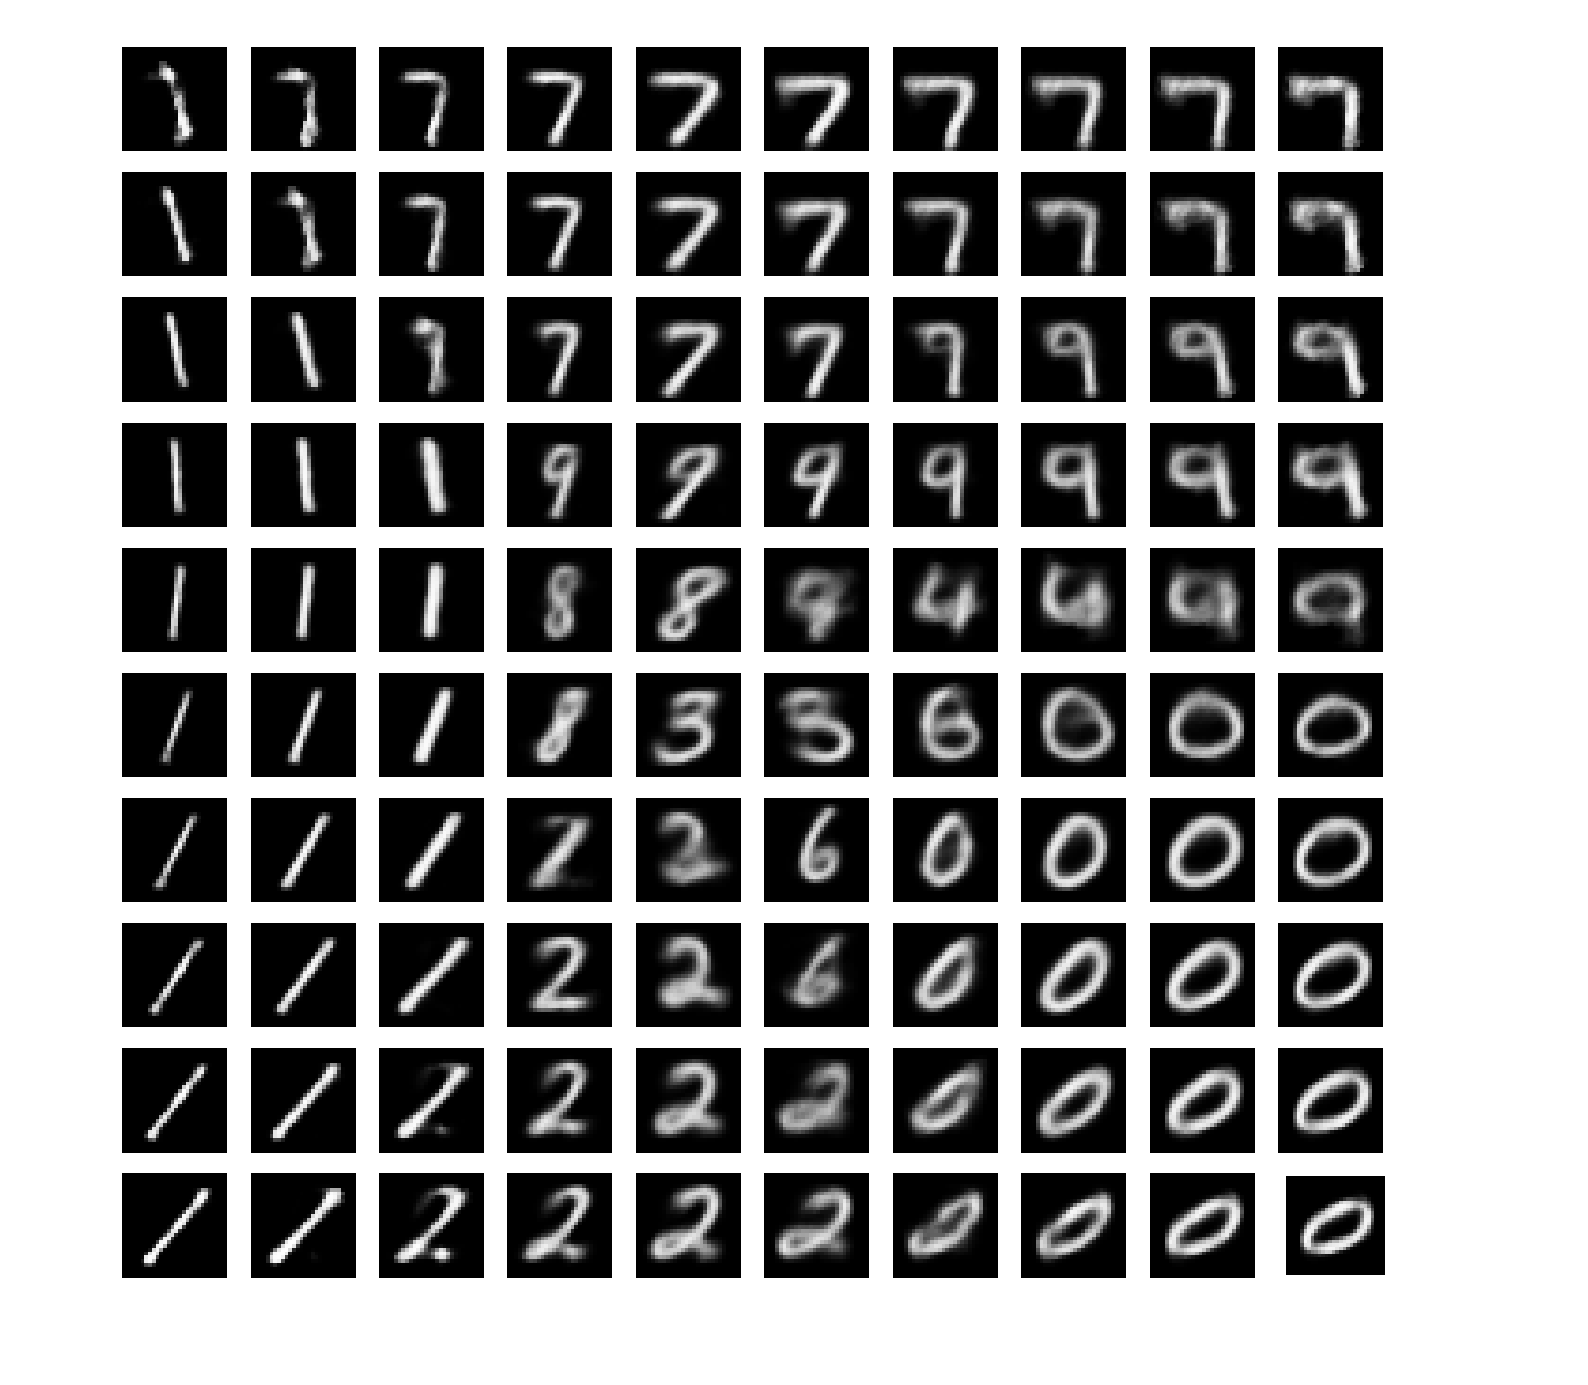

In [5]:
import matplotlib.pyplot as plt
import PIL
idx = 0
fig = plt.figure(figsize=(5, 5), dpi=326)
x_list = np.linspace(-3, 3, 10)
y_list = np.linspace(-3, 3, 10)
with torch.no_grad():
    for i in x_list:
        for j in y_list:
            idx += 1
            ax = plt.subplot(10, 10, idx)
            ax.axis("off")
            z = torch.Tensor((i, j)).cuda()
            x_dist = model.decode(z)
            img = x_dist.probs.view(28, 28)
            ax.imshow(PIL.Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8), mode="L"))
plt.xticks(x_list, [str(_) for _ in x_list])
plt.show()
plt.close("all")

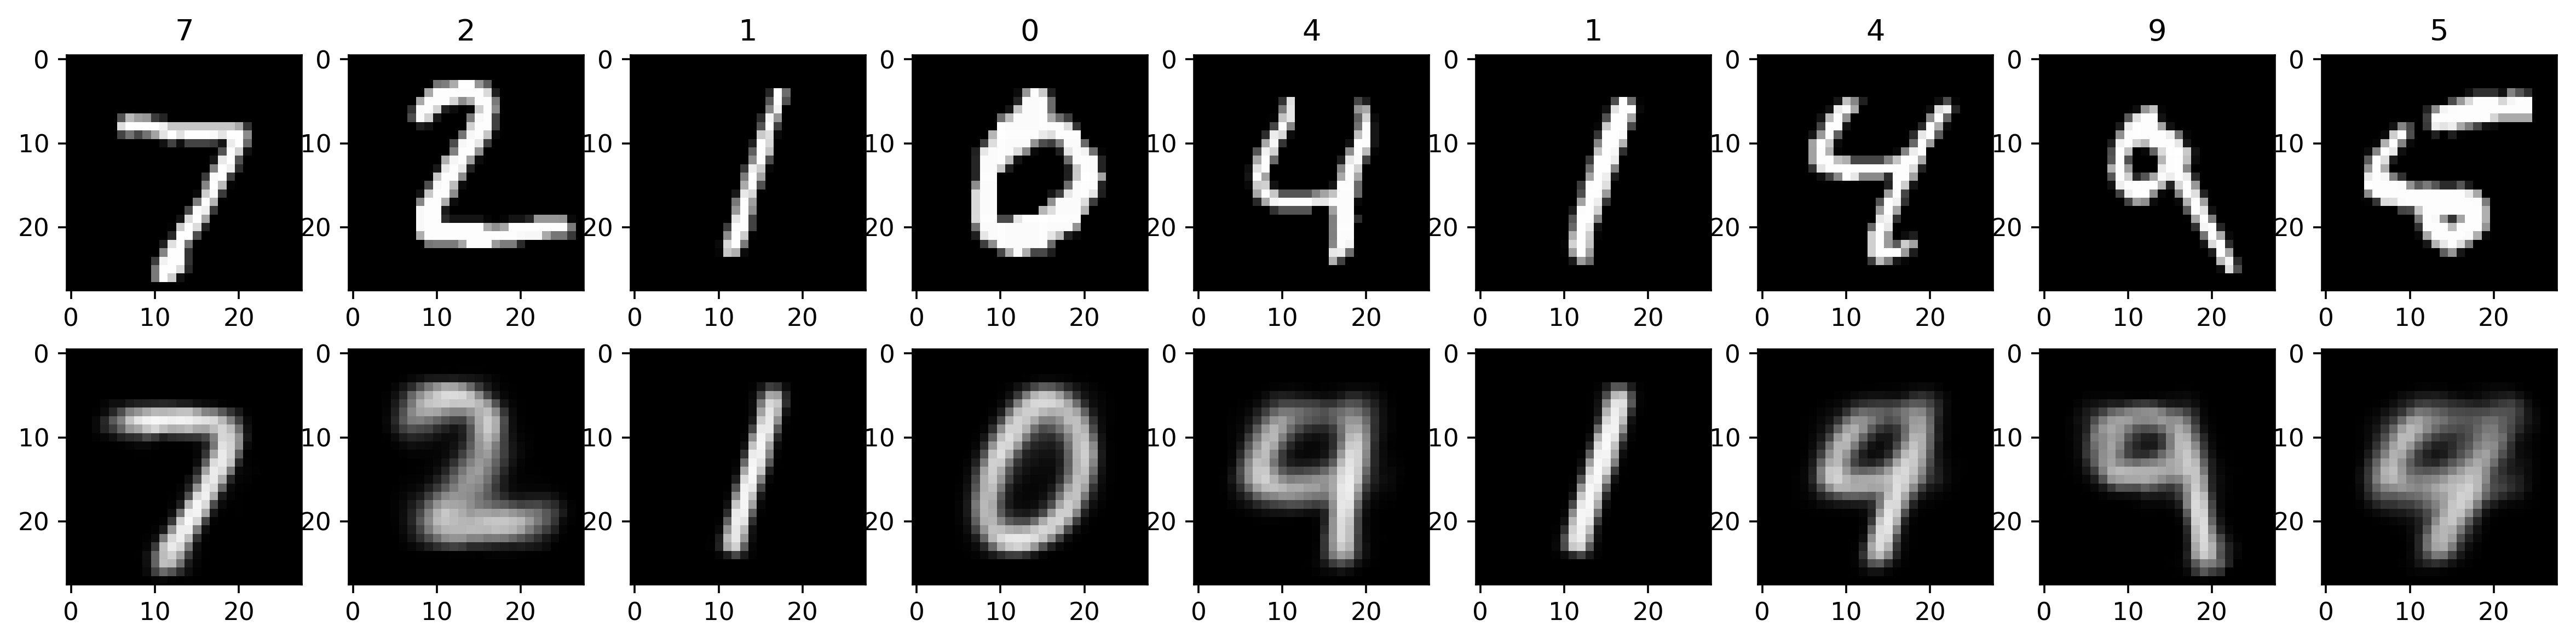

In [10]:
import matplotlib.pyplot as plt
import PIL
fig = plt.figure(figsize=(18, 4), dpi=326)
with torch.no_grad():
    for i in range(9):
        x, y = mnist_test_data[i]
        plt.subplot(2, 9, i + 1)  
        plt.imshow(PIL.Image.fromarray((x.numpy()).astype(np.uint8), mode="L"))
        plt.title(f"{y}")
        
        plt.subplot(2, 9, i + 10)
        x_dist = model.reconstruct(torch.unsqueeze(x.view(1, 784) / 255, 0).cuda())
        img = x_dist.mean.view(28, 28)
        plt.imshow(PIL.Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8), mode="L"))
plt.show()
plt.close("all")